# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [42]:
# Se importa las librerias necesirias. Para Request fue necesario instalar por terminal "pandas request"
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [35]:
#El siguiente paso es validar la consulta del HTML
URL = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
html_tesla = requests.get(URL, headers = headers)


In [36]:
#Hacer la validación para conectarse usando Chrome y generar el arbol de elementos.
if html_tesla:
    soup = BeautifulSoup(html_tesla.text,"html")
    soup

In [37]:
#buscamos las tablas
tables = soup.find_all("table")  
tables

[<table class="historical_data_table table">
 <thead>
 <tr>
 <th colspan="2" style="text-align:center">Tesla Annual Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td style="text-align:center">2024</td>
 <td style="text-align:center">$97,690</td>
 </tr>
 <tr>
 <td style="text-align:center">2023</td>
 <td style="text-align:center">$96,773</td>
 </tr>
 <tr>
 <td style="text-align:center">2022</td>
 <td style="text-align:center">$81,462</td>
 </tr>
 <tr>
 <td style="text-align:center">2021</td>
 <td style="text-align:center">$53,823</td>
 </tr>
 <tr>
 <td style="text-align:center">2020</td>
 <td style="text-align:center">$31,536</td>
 </tr>
 <tr>
 <td style="text-align:center">2019</td>
 <td style="text-align:center">$24,578</td>
 </tr>
 <tr>
 <td style="text-align:center">2018</td>
 <td style="text-align:center">$21,461</td>
 </tr>
 <tr>
 <td style="text-align:center">2017</td>
 <td style="text-align:center">$11,759</td>
 </tr>
 

In [38]:
for index, table in enumerate(tables):
        if ("Tesla Quarterly Revenue" in str(table)):
                table_index = index
                break
table_index


1

In [40]:
tables[1]==table

True

In [53]:
# Crear el DataFrame y hacer la limpieza de datos
tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
for row in table.tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        Date = col[0].text
        Revenue = col[1].text.replace("$", "").replace(",", "").strip()
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": Date,
            "Revenue": Revenue
        }, index = [0])], ignore_index = True)



In [54]:
tesla_revenue

,Date,Revenue
0,2024-12-31,25707
1,2024-09-30,25182
2,2024-06-30,25500
3,2024-03-31,21301
4,2023-12-31,25167
...,...,...
58,2010-06-30,28
59,2010-03-31,21
60,2009-12-31,
61,2009-09-30,46


In [8]:
# se crea la BD
connection = sqlite3.connect("Tesla.db")
connection



In [9]:
# se crea la tabla
cursor = connection.cursor()
cursor.execute("""CREATE TABLE revenue (Company, Revenue)""")

OperationalError: table revenue already exists

In [31]:
# Se inserta los valores en la tabla revenue

tesla = list(tesla_revenue.to_records(index = False))

cursor.executemany("INSERT INTO revenue VALUES (?,?)", tesla)
connection.commit()

In [10]:
# se revisa la tabla de sql
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

('2024-12-31', '25,707')
('2024-09-30', '25,182')
('2024-06-30', '25,500')
('2024-03-31', '21,301')
('2023-12-31', '25,167')
('2023-09-30', '23,350')
('2023-06-30', '24,927')
('2023-03-31', '23,329')
('2022-12-31', '24,318')
('2022-09-30', '21,454')
('2022-06-30', '16,934')
('2022-03-31', '18,756')
('2021-12-31', '17,719')
('2021-09-30', '13,757')
('2021-06-30', '11,958')
('2021-03-31', '10,389')
('2020-12-31', '10,744')
('2020-09-30', '8,771')
('2020-06-30', '6,036')
('2020-03-31', '5,985')
('2019-12-31', '7,384')
('2019-09-30', '6,303')
('2019-06-30', '6,350')
('2019-03-31', '4,541')
('2018-12-31', '7,226')
('2018-09-30', '6,824')
('2018-06-30', '4,002')
('2018-03-31', '3,409')
('2017-12-31', '3,288')
('2017-09-30', '2,985')
('2017-06-30', '2,790')
('2017-03-31', '2,696')
('2016-12-31', '2,285')
('2016-09-30', '2,298')
('2016-06-30', '1,270')
('2016-03-31', '1,147')
('2015-12-31', '1,214')
('2015-09-30', '937')
('2015-06-30', '955')
('2015-03-31', '940')
('2014-12-31', '957')
('2014-

In [57]:
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = pd.to_numeric(tesla_revenue["Revenue"])

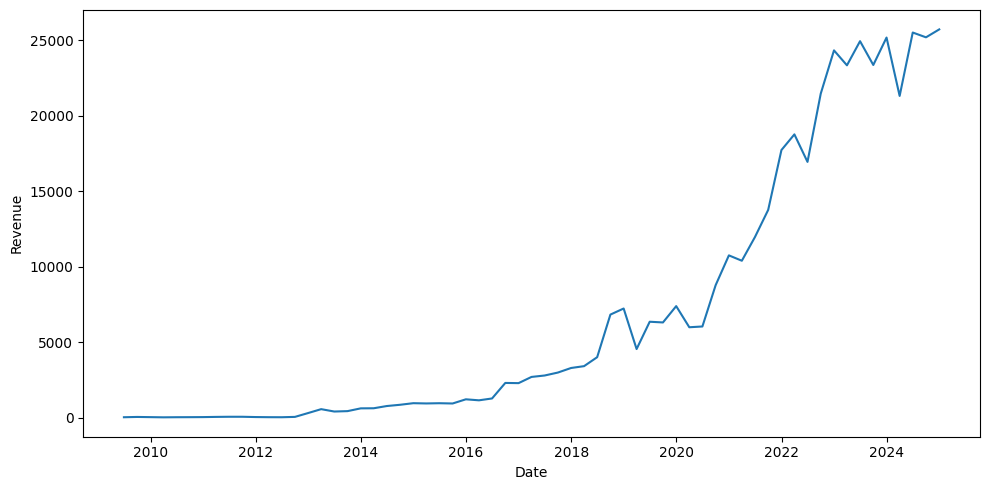

In [62]:
# evolución de ganancia de Tesla en el tiempo

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")
plt.tight_layout()
plt.show()

In [70]:
# promedio móvil a 1 año
tesla_revenue['Year_MM'] = tesla_revenue['Revenue'].rolling(4).mean()
tesla_revenue['Semester_MM'] = tesla_revenue['Revenue'].rolling(2).mean()

tesla_revenue

,Date,Revenue,Year_MM,Semester_MM
0,2024-12-31,25707.0,NaN,NaN
1,2024-09-30,25182.0,NaN,25444.5
2,2024-06-30,25500.0,NaN,25341.0
3,2024-03-31,21301.0,24422.5,23400.5
4,2023-12-31,25167.0,24287.5,23234.0
...,...,...,...,...
58,2010-06-30,28.0,36.0,29.5
59,2010-03-31,21.0,29.0,24.5
60,2009-12-31,NaN,NaN,NaN
61,2009-09-30,46.0,NaN,NaN


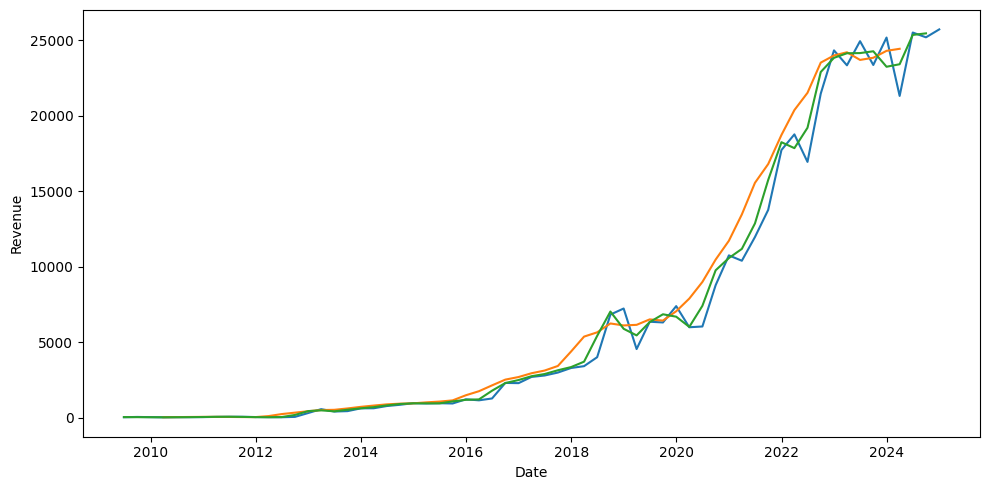

In [ ]:
# graficar con promedios móviles a un año y semestre.
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")
sns.lineplot(data = tesla_revenue, x = "Date", y = "Year_MM")
sns.lineplot(data = tesla_revenue, x = "Date", y = "Semester_MM")
plt.tight_layout()
plt.show()

In [89]:
tesla_revenue.describe()


,Date,Revenue,Year_MM,Semester_MM
count,63,62.000000,57.000000,60.000000
mean,2017-03-31 03:48:34.285714176,7034.612903,6978.758772,7054.091667
min,2009-06-30 00:00:00,21.000000,29.000000,24.500000
25%,2013-05-15 12:00:00,463.750000,609.000000,513.125000
50%,2017-03-31 00:00:00,2743.000000,2939.750000,2815.250000
75%,2021-02-14 00:00:00,10655.250000,10465.500000,10718.250000
max,2024-12-31 00:00:00,25707.000000,24422.500000,25444.500000
std,NaN,8798.039766,8412.366048,8675.717424
